In [1]:
import pandas as pd
import numpy as np

In [256]:
orders = pd.read_csv('C:/Users/User/PYTHON/данные/affiliate_orders.csv')
affiliates = pd.read_csv('C:/Users/User/PYTHON/данные/affiliates.csv', sep = ';')

#переименуем для последующего merge
affiliates = affiliates.rename(columns = {'id':'affiliate_id', 'created_at':'start_cooperation'})

In [184]:
len(orders) #257914 наблюдений; 204 уникальных ID
orders['affiliate_id'].value_counts()

len(affiliates) #4321 наблюдений; 4321 уникальных ID

In [190]:
#orders['year'] = pd.DatetimeIndex(orders['created_at']).year
#orders['month'] = pd.DatetimeIndex(orders['created_at']).month
#orders['day'] = pd.DatetimeIndex(orders['created_at']).day

In [191]:
#считаем количество операций для каждого партнера
held = orders[orders.state == 'held'].groupby('affiliate_id', as_index = False).aggregate({'state' : 'count'})
canceled = orders[orders.state == 'canceled'].groupby('affiliate_id', as_index = False).aggregate({'state' : 'count'})
pending = orders[orders.state == 'pending'].groupby('affiliate_id', as_index = False).aggregate({'state' : 'count'})

#соединяем все в одну табличку, заполняем строки с NA статусом нулями
merged = held.merge(canceled, on = 'affiliate_id', how = 'outer').merge(pending, on = 'affiliate_id', how = 'outer')
merged = merged.rename(columns = {'affiliate_id':'affiliate_id', 'state_x':'held', 'state_y':'canceled', 'state':'pending'})
merged[['held', 'canceled', 'pending']] = merged[['held', 'canceled', 'pending']].fillna(0)

In [249]:
#выделем долю успешных, неуспешных (отмененных) экскурсий
merged['held_share'] = merged.held/(merged.held+merged.canceled+merged.pending)
merged['cancel_share'] = merged.canceled/(merged.held+merged.canceled+merged.pending)

#успешные/неуспешные (если > 1, то партнер справляется)
merged['success_measure'] = merged['held_share']/merged['cancel_share']

#количество запросов на экскурсии в целом
merged['num'] = merged.held+merged.canceled+merged.pending

merged

,affiliate_id,held,canceled,pending,held_share,cancel_share,success_measure,num
0,1,5429.0,4035.0,578.0,0.540629,0.401812,1.345477,10042.0
1,9,18.0,7.0,1.0,0.692308,0.269231,2.571429,26.0
2,45,2.0,3.0,0.0,0.400000,0.600000,0.666667,5.0
3,106,1.0,0.0,0.0,1.000000,0.000000,inf,1.0
4,114,6.0,5.0,0.0,0.545455,0.454545,1.200000,11.0
...,...,...,...,...,...,...,...,...
199,5042,0.0,1.0,1.0,0.000000,0.500000,0.000000,2.0
200,131,0.0,0.0,1.0,0.000000,0.000000,NaN,1.0
201,4650,0.0,0.0,1.0,0.000000,0.000000,NaN,1.0
202,4928,0.0,0.0,2.0,0.000000,0.000000,NaN,2.0


In [204]:
#соединим таблицу с долями и трафиком
full_table = affiliates.merge(merged, on = 'affiliate_id', how = 'outer')

#сделаем колонки для года, месяца, ня отдельно
full_table['year'] = pd.DatetimeIndex(full_table['start_cooperation']).year
full_table['month'] = pd.DatetimeIndex(full_table['start_cooperation']).month
full_table['day'] = pd.DatetimeIndex(full_table['start_cooperation']).day
full_table['time'] = pd.DatetimeIndex(full_table['start_cooperation']).time

#посчитаем конверсию: успешные экскурсии/трафик
full_table['conversion'] = full_table.held/full_table.traffic_amount

full_table

,affiliate_id,start_cooperation,traffic_amount,held,canceled,pending,held_share,cancel_share,success_measure,num,year,month,day,time,conversion
0,151,2014-08-22 20:04:38.223152,1434704,84491.0,60109.0,13396.0,0.534767,0.380446,1.405630,157996.0,2014,8,22,20:04:38.223152,0.058891
1,3792,2020-03-19 11:22:41.411688,653855,2815.0,1443.0,1076.0,0.527747,0.270529,1.950797,5334.0,2020,3,19,11:22:41.411688,0.004305
2,2513,2018-10-03 16:51:52.393059,381085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,10,3,16:51:52.393059,NaN
3,2704,2019-03-13 16:12:12.506301,360855,5.0,11.0,1.0,0.294118,0.647059,0.454545,17.0,2019,3,13,16:12:12.506301,0.000014
4,3340,2019-06-06 16:25:01.741799,180385,1583.0,867.0,487.0,0.538985,0.295199,1.825836,2937.0,2019,6,6,16:25:01.741799,0.008776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4316,2935,2019-04-25 12:56:54.878422,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,4,25,12:56:54.878422,NaN
4317,1821,2018-07-06 23:19:24.203316,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,7,6,23:19:24.203316,NaN
4318,806,2016-04-17 12:45:29.030112,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,4,17,12:45:29.030112,NaN
4319,4468,2022-05-01 23:54:09.875088,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,5,1,23:54:09.875088,NaN


In [ ]:
@НАИБОЛЕЕ ХОРОШИЕ ПАРТНЕРЫ

In [205]:
#отберем лучшие 95% по количеству заказов, отсортируем по конверсии
top_95 = full_table[(full_table['num'] >= full_table['num'].quantile(0.95))].sort_values('conversion', ascending = False)

#held_share/cancel_share >= 1
successfull = top_95[top_95.success_measure >=1 ]


#итак, мы отобрали 95% лучших по заказам партнеров
#у которых доля проведенных экскурсий превышает долю отмененных
#отсортировали данные по конверсии (число успешных экскурсий/трафик)
successfull[['affiliate_id', 'traffic_amount', 'num', 'success_measure', 'conversion']]

#affiliate_id = 3618 не привлекает трафик, однако проводит успешные экскурсии 
#это либо ошибка в данных, либо на самом сайте партнера можно как-то забронировать экскурсию

,affiliate_id,traffic_amount,num,success_measure,conversion
4305,3618,0,14506.0,1.749763,inf
10,1032,42860,4702.0,1.819220,0.063159
0,151,1434704,157996.0,1.405630,0.058891
8,2132,87665,8814.0,1.629054,0.056157
6,1,105208,10042.0,1.345477,0.051603
7,555,92118,6574.0,1.284370,0.038538
5,3421,108881,6419.0,1.498294,0.032255
4,3340,180385,2937.0,1.825836,0.008776
1,3792,653855,5334.0,1.950797,0.004305


In [250]:
#все партнеры, которые не приносят трафик, однако каким-то образом все равно организуют экскурсии

weird = full_table[(full_table['traffic_amount'] == 0) & (~full_table['held'].isnull()) & (full_table['held'] > 0)]
weird[['affiliate_id', 'traffic_amount', 'held', 'canceled', 'pending']]

,affiliate_id,traffic_amount,held,canceled,pending
1227,1683,0,2117.0,2603.0,1.0
2187,4112,0,8.0,22.0,1.0
2567,278,0,3.0,5.0,0.0
2887,4537,0,1.0,1.0,1.0
2945,4452,0,2.0,2.0,0.0
3179,4370,0,6.0,3.0,0.0
3340,1772,0,25.0,39.0,0.0
3443,630,0,2.0,0.0,0.0
4044,4536,0,5.0,10.0,0.0
4305,3618,0,9230.0,5275.0,1.0


In [ ]:
@НАИМЕНЕЕ ХОРОШИЕ ПАРТНЕРЫ

In [235]:
#сперва определим, с какими партнерами мы слишком недавно общаемся (начали общение в июне)

full_table[(full_table['year'] >= 2023) & (full_table['month'] >= 6)]

len(full_table) - len(full_table[(full_table['year'] >= 2023) & (full_table['month'] >= 6)])
#4225 адекватных данных

#данные про партнеров, которые начали с нами отношения до июня
relevant_table = full_table[full_table['start_cooperation'] < '2023-06-01 16:55:47.652983'].sort_values('start_cooperation', ascending = False)

In [252]:
#отберем худшие 5% из (релевантных партнеров) по количеству заказов, отсортируем по конверсии
low_05 = relevant_table[(relevant_table['num'] <= relevant_table['num'].quantile(0.05))].sort_values('traffic_amount', ascending = False)

#мы отобрали 5% худших по заказам партнеров
#отсортировали данные по трафику
low_05[['affiliate_id', 'traffic_amount', 'held', 'canceled', 'success_measure', 'conversion']]

#многие приносят 0 трафик, а многие - ненулевой, но заказов все равно мало
#возможно, эти партнеры не совсем подходят нам по тематике, либо ценовой сегмент выбран неверно
#(сайт посещают бедные, а цены у нас оч высокие, к примеру)

,affiliate_id,traffic_amount,held,canceled,success_measure,conversion
27,2355,5408,1.0,0.0,inf,0.000185
46,4541,1265,0.0,1.0,0.0,0.000000
72,4730,525,0.0,1.0,0.0,0.000000
81,635,415,0.0,1.0,0.0,0.000000
117,4851,146,1.0,0.0,inf,0.006849
131,1656,107,0.0,1.0,0.0,0.000000
136,4925,96,0.0,1.0,0.0,0.000000
139,291,89,1.0,0.0,inf,0.011236
140,938,88,1.0,0.0,inf,0.011364
151,4652,73,0.0,1.0,0.0,0.000000


In [253]:
#про нулевой трафик

len(affiliates) - len(relevant_table[(relevant_table['traffic_amount'] == 0)])
#у нас всего 562 давних партнера с НЕнулевым трафиком

len(relevant_table[(relevant_table['traffic_amount'] == 0) & (relevant_table['held'].isnull())])
#3738 с нулевым трафиком и отсутствующими (либо нулевыми) данными по успешным экскурсиям

3738

In [ ]:
@ДАВНИЕ ПАРТНЕРЫ С ПЛОХОЙ КОНВЕРСИЕЙ

In [292]:
#oldmens = full_table[(full_table['year'] < 2017)]
oldmens = full_table[(full_table['year'] < 2022)]
bad_oldmens = oldmens[oldmens['conversion'] == 0]

bad_oldmens[['affiliate_id', 'start_cooperation', 'traffic_amount', 'held', 'canceled', 'pending', 'conversion']]

,affiliate_id,start_cooperation,traffic_amount,held,canceled,pending,conversion
36,397,2015-03-24 18:57:33.643494,2155,0.0,5.0,1.0,0.0
62,305,2014-12-25 15:32:00.655285,634,0.0,2.0,0.0,0.0
81,635,2015-11-10 00:41:41.424702,415,0.0,1.0,0.0,0.0
131,1656,2018-04-11 04:57:58.218179,107,0.0,1.0,0.0,0.0
135,199,2014-09-25 10:51:23.487892,98,0.0,2.0,0.0,0.0
156,1507,2017-12-01 13:13:24.181698,68,0.0,1.0,1.0,0.0
172,1509,2017-12-04 09:33:01.041237,50,0.0,3.0,0.0,0.0
182,4299,2021-11-04 09:00:55.197664,41,0.0,1.0,0.0,0.0
199,483,2015-06-09 09:48:12.309395,33,0.0,2.0,0.0,0.0
200,3748,2020-03-08 17:32:55.856457,32,0.0,1.0,0.0,0.0


In [ ]:
@ПРОГНОЗ

In [383]:
#подготовка данных

orders['created_at'] = pd.to_datetime(orders['created_at'])
orders['ymd'] = orders['created_at'].dt.strftime('%Y-%m-%d')

forecast_data = orders.groupby('ymd', as_index = False).aggregate({'state' : 'count'})
forecast_data

In [ ]:
!pip install pmdarima
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

smodel = pm.auto_arima(forecast_data.state, start_p = 1, start_q = 1,
                         test = 'adf',
                         max_p = 3, max_q = 3, m = 10,
                         start_P = 0, seasonal = True,
                         d = None, D = 1, trace = True,
                         error_action = 'ignore',  
                         suppress_warnings = True, 
                         stepwise = True)

smodel.summary()

In [415]:
#строим предсказание согласно лучшей модели (2,0,1)(2,1,0,10)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(forecast_data['state'], order = (2,0,1), seasonal_order = (2, 1, 0, 10))
model_fit = model.fit()
forecast = model_fit.forecast(steps = 60)
print(forecast)

425    1259.562445
426    1272.817844
427    1138.821291
428    1246.409096
429    1115.014869
430    1231.589430
431    1279.968913
432    1270.868334
433    1276.680888
434    1271.460571
435    1372.664945
436    1388.418055
437    1215.784458
438    1339.258817
439    1079.927333
440    1220.285997
441    1264.200606
442    1269.728735
443    1276.327200
444    1250.701862
445    1353.153868
446    1383.942025
447    1209.472047
448    1329.988976
449    1040.460090
450    1196.107507
451    1250.656053
452    1274.085645
453    1276.795813
454    1246.850716
455    1343.382247
456    1363.170215
457    1199.637863
458    1317.547541
459    1081.126412
460    1220.119770
461    1268.515685
462    1276.013658
463    1280.799059
464    1258.792213
465    1358.650434
466    1381.508662
467    1211.035766
468    1331.236128
469    1067.561414
470    1213.335678
471    1262.826755
472    1275.965561
473    1280.256911
474    1254.015790
475    1353.106581
476    1376.707496
477    1207.

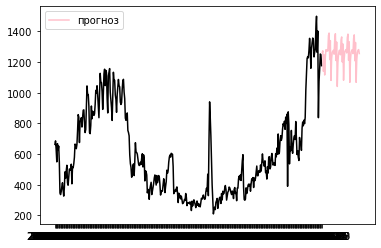

In [414]:
plt.plot(forecast_data.ymd, forecast_data.state, color = 'black')
plt.plot(forecast, label = 'прогноз', color = 'pink')
plt.legend(loc = "upper left")
plt.show()

In [432]:
#это я пытаюсь соединить даты с прогнозными значениями..

import datetime

test_date = datetime.datetime.strptime("01-8-2023", "%d-%m-%Y")
K = 61
 
date_generated = pd.date_range(test_date, periods = K)

,0
0,2023-08-01
1,2023-08-02
2,2023-08-03
3,2023-08-04
4,2023-08-05
...,...
56,2023-09-26
57,2023-09-27
58,2023-09-28
59,2023-09-29
